## Feature Extraction Using PCA for Image Classification
### Team Members: Mary Aiyetigbo and Venkatesh Velidimalla

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn, optim, flatten
from torch.nn import Linear, Conv2d, MaxPool2d, BatchNorm2d, Module, Dropout, ReLU
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random as rd
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
rd.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("available core is", device)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


available core is cuda


In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),])

trainset = datasets.MNIST('./', download=True, train=True,  transform=transform)
testset = datasets.MNIST('./', download=True, train=False, transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True, drop_last=True)

train_images = trainloader.dataset.data.detach().numpy().reshape(-1, 28*28)
train_image = train_images / 255
labels = trainloader.dataset.targets
#train_images.shape

In [3]:
 def pca_fn(train_images, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(train_images)
    return pca #, train_images_reduced

Text(0.5, 1.0, 'Variance retained for 100 PCs (%): 91.42500736237783')

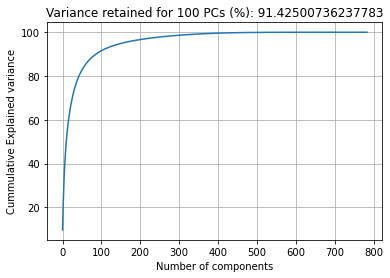

In [4]:
pca_784 = pca_fn(train_images, 784)
plt.grid()
plt.plot(np.cumsum(pca_784.explained_variance_ratio_ * 100))
plt.xlabel('Number of components')
plt.ylabel('Cummulative Explained variance')
plt.title(f"Variance retained for 100 PCs (%): {str(np.sum(pca_fn(train_images, 100).explained_variance_ratio_ * 100))}")

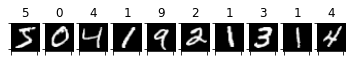

In [5]:
for i in range(10):
    ax = plt.subplot(2,10,i+1)
    ax.imshow(train_images[i].reshape(28,28), cmap="gray")
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title(str(labels[i].item()))

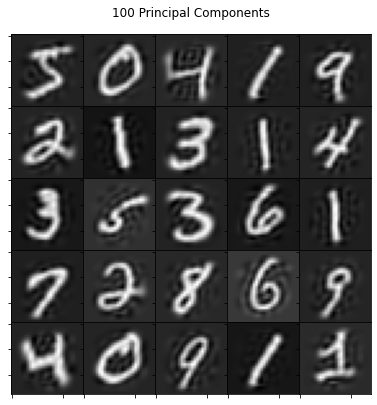

In [6]:
from matplotlib import gridspec
nrow = 5
ncol = 5
pc=100
fig = plt.figure(figsize=(ncol+1, nrow+1)) 

gs = gridspec.GridSpec(nrow, ncol,wspace=0.0, hspace=0.0, 
         top=1.-0.5/(nrow+1), bottom=0.5/(nrow+1), 
         left=0.5/(ncol+1), right=1-0.5/(ncol+1)) 

index=0
pca = pca_fn(train_images, pc)
images_reduced = pca.transform(train_images)
images_reduced = pca.inverse_transform(images_reduced)
for i in range(nrow):
    for j in range(ncol):
        ax= plt.subplot(gs[i,j])
        ax.imshow(images_reduced[index].reshape(28,28), cmap='gray')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        index+=1
plt.suptitle(f'{str(pc)} Principal Components')
plt.show()

### Models

In [39]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)       
        return x
    
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1,8, kernel_size=3,stride=1,padding=1)
        self.pool = MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = Conv2d(8,16, kernel_size=3,stride=1,padding=1)
        self.fc1 = nn.Linear(16*7*7,256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64,10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x) 
        #flatten
        x = x.reshape(x.shape[0], -1)
        #x = F.dropout(F.relu(self.fc1(x)), p=0.2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)  
        return x
    
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [8]:
# Hyperparameters
epochs = 20
loss_fn = nn.CrossEntropyLoss()
lr = 0.001

### MLP ONLY

In [9]:
pca_components = [10, 25, 50, 100]
mlp_loss = []
mlp_acc = []
mlp_test_acc = []
mlp_test_loss = []

print(f"============================================== MLP ONLY ==============================================")
mlp_model = MLP(input_dim=784)
mlp_model.to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=lr)
step =0
i=0
for e in range(epochs):
    train_loss = 0
    trainacc = 0
    mlp_model.train()
    for images, labels in trainloader:
        step+=1
        optimizer.zero_grad()
        images = images.view(images.shape[0], -1)
        images = torch.Tensor(images)
        images, labels = images.to(device), labels.to(device)
        logps = mlp_model(images) #forward propagation
        loss = loss_fn(logps, labels) #calculate loss
        loss.backward() #backward propagation
        optimizer.step() #update weights
        loss = loss.item()
        train_loss+=loss
        _, pred = logps.max(1)
        trainacc += (pred == labels).sum().item()


    with torch.no_grad():
        mlp_model.eval()
        acc = 0
        testloss = 0
        for images, labels in testloader:
            images = images.view(images.shape[0], -1)
            images = torch.Tensor(images)
            images, labels = images.to(device), labels.to(device)
            output = mlp_model(images)
            testloss += loss_fn(output, labels).item()
            _, pred = output.max(1)
            acc += (pred == labels).sum().item()

        if (e+1)%5 == 0:
            print("Epoch: {}/{}  Step:{}  Train Loss: {:.6f}  Train Acc: {:.2f}%  Val Loss: {:.6f}  Val Acc: {:.2f}%"\
                  .format(e+1, epochs, step, train_loss/len(trainloader), trainacc/len(trainset)*100, testloss/len(testloader), acc/len(testset)*100))

        mlp_loss.append(train_loss/len(trainloader))
        mlp_acc.append(trainacc/len(trainset))
        mlp_test_acc.append(acc/len(testset))
        mlp_test_loss.append(testloss/len(testloader))


============================================== MLP ONLY ==============================================
Epoch: 5/20  Step:2340  Train Loss: 0.088652  Train Acc: 97.08%  Val Loss: 0.096034  Val Acc: 96.85%
Epoch: 10/20  Step:4680  Train Loss: 0.046936  Train Acc: 98.33%  Val Loss: 0.077983  Val Acc: 97.56%
Epoch: 15/20  Step:7020  Train Loss: 0.029733  Train Acc: 98.81%  Val Loss: 0.088993  Val Acc: 97.45%
Epoch: 20/20  Step:9360  Train Loss: 0.021926  Train Acc: 99.07%  Val Loss: 0.091605  Val Acc: 97.58%


## PCA WITH MLP

In [46]:
pca_components = [10, 25, 100]
pca_model_loss = {i:[] for i in range(len(pca_components))}
pca_model_acc = {i:[] for i in range(len(pca_components))}
pca_test_acc = {i:[] for i in range(len(pca_components))}
pca_test_loss = {i:[] for i in range(len(pca_components))}
pca_params = []
for i, n_components in enumerate(pca_components):
    print(f"====================================Using {str(pca_components[i])} Principal Components====================================")
    pca = pca_fn(train_image, n_components)
    pca_model = MLP(input_dim = n_components)
    pca_model.to(device)
    optimizer = optim.Adam(pca_model.parameters(), lr=lr)
    step =0
    pca_params.append(count_parameters(pca_model))
    for e in range(epochs):
        train_loss = 0
        trainacc = 0
        for img, labels in trainloader:
            pca_model.train()
            step+=1
            images = img.view(img.shape[0], -1)
            images = pca.transform(images)
            images = torch.Tensor(images)
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logps = pca_model(images) #forward propagation
            loss = loss_fn(logps, labels) #compute loss
            loss.backward() #backward propagation
            optimizer.step() #update weights
            loss = loss.item()
            train_loss+=loss
            _, pred = logps.max(1)
            trainacc += (pred == labels).sum().item()


        with torch.no_grad():
            pca_model.eval()
            acc = 0
            testloss = 0
            for images, labels in testloader:
                images = images.view(images.shape[0], -1)
                images = pca.transform(images)
                images = torch.Tensor(images)
                images, labels = images.to(device), labels.to(device)
                output = pca_model(images)
                testloss += loss_fn(output, labels).item()
                _, pred = output.max(1)
                acc += (pred == labels).sum().item()

            if (e+1)%5 == 0:
                print("Epoch: {}/{}  Step:{}  Train Loss: {:.6f}  Train Acc: {:.2f}%  Val Loss: {:.6f}  Val Acc: {:.2f}%"\
                      .format(e+1, epochs, step, train_loss/len(trainloader), trainacc/len(trainset)*100, testloss/len(testloader), acc/len(testset)*100))

            pca_model_loss[i].append(train_loss/len(trainloader))
            pca_model_acc[i].append(trainacc/len(trainset))
            pca_test_acc[i].append(acc/len(testset))
            pca_test_loss[i].append(testloss/len(testloader))


====================================Using 10 Principal Components====================================
Epoch: 5/20  Step:2340  Train Loss: 0.228681  Train Acc: 92.27%  Val Loss: 0.227494  Val Acc: 92.33%
Epoch: 10/20  Step:4680  Train Loss: 0.193902  Train Acc: 93.36%  Val Loss: 0.207861  Val Acc: 93.13%
Epoch: 15/20  Step:7020  Train Loss: 0.170880  Train Acc: 94.16%  Val Loss: 0.206707  Val Acc: 93.17%
Epoch: 20/20  Step:9360  Train Loss: 0.155970  Train Acc: 94.58%  Val Loss: 0.190032  Val Acc: 93.68%
====================================Using 25 Principal Components====================================
Epoch: 5/20  Step:2340  Train Loss: 0.082343  Train Acc: 97.34%  Val Loss: 0.088592  Val Acc: 97.01%
Epoch: 10/20  Step:4680  Train Loss: 0.048662  Train Acc: 98.31%  Val Loss: 0.076269  Val Acc: 97.43%
Epoch: 15/20  Step:7020  Train Loss: 0.032081  Train Acc: 98.78%  Val Loss: 0.079614  Val Acc: 97.53%
Epoch: 20/20  Step:9360  Train Loss: 0.021690  Train Acc: 99.13%  Val Loss: 0.090614

## CNN

In [13]:
cnn_loss = []
cnn_acc = []
cnn_test_acc = []
cnn_test_loss = []
print(f"=============================================== CNN ===============================================")
cnn_model = CNN()
cnn_model.to(device)
optimizer = optim.Adam(cnn_model.parameters(), lr=lr)
step =0
for e in range(epochs):
    train_loss = 0
    trainacc = 0
    cnn_model.train()
    for images, labels in trainloader:
        step+=1
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        logps = cnn_model(images) #forward propagation
        loss = loss_fn(logps, labels) #calculate loss
        loss.backward() #backward propagation
        optimizer.step() #update weights
        loss = loss.item()
        train_loss+=loss
        _, pred = logps.max(1)
        trainacc += (pred == labels).sum().item()
    with torch.no_grad():
        cnn_model.eval()
        acc = 0
        testloss = 0
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            output = cnn_model(images)
            testloss += loss_fn(output, labels).item()
            _, pred = output.max(1)
            acc += (pred == labels).sum().item()

        if (e+1)%5 == 0:
            print("Epoch: {}/{}  Step:{}  Train Loss: {:.6f}  Train Acc: {:.2f}%  Val Loss: {:.6f}  Val Acc: {:.2f}%"\
                  .format(e+1, epochs, step, train_loss/len(trainloader), trainacc/len(trainset)*100, testloss/len(testloader), acc/len(testset)*100))

        cnn_loss.append(train_loss/len(trainloader))
        cnn_acc.append(trainacc/len(trainset))
        cnn_test_acc.append(acc/len(testset))
        cnn_test_loss.append(testloss/len(testloader))
cnn_params = count_parameters(cnn_model)

=============================================== CNN ===============================================
Epoch: 5/20  Step:2340  Train Loss: 0.035475  Train Acc: 98.79%  Val Loss: 0.035167  Val Acc: 98.63%
Epoch: 10/20  Step:4680  Train Loss: 0.012833  Train Acc: 99.42%  Val Loss: 0.040309  Val Acc: 98.69%
Epoch: 15/20  Step:7020  Train Loss: 0.006995  Train Acc: 99.61%  Val Loss: 0.039486  Val Acc: 98.85%
Epoch: 20/20  Step:9360  Train Loss: 0.002795  Train Acc: 99.75%  Val Loss: 0.043143  Val Acc: 98.92%


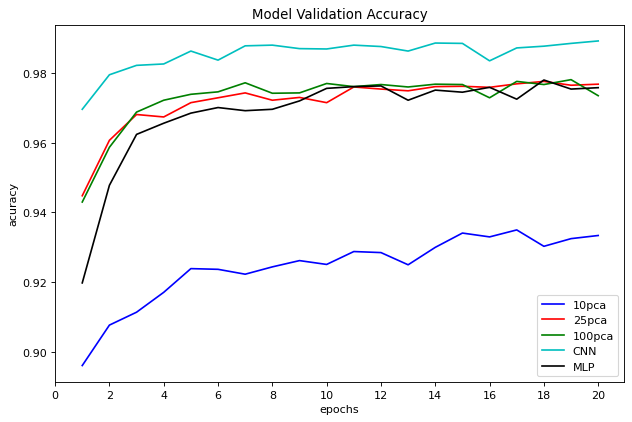

In [45]:
fig = plt.figure(figsize=(8,10), dpi=80)
plt.subplot(2,1,2)
col = ['b', 'r', 'g', 'c', 'black', 'y']
labels = []
for i in range(3):
    plt.plot(np.arange(1,epochs+1), pca_test_acc[i], col[i], label=str(pca_components[i])+'pca')
plt.plot(np.arange(1,epochs+1), cnn_test_acc, col[3], label='CNN')
plt.plot(np.arange(1,epochs+1), mlp_test_acc, col[4], label='MLP')
plt.title('Model Validation Accuracy')
plt.ylabel('acuracy')
plt.xlabel('epochs')
plt.xticks(np.arange(0,22,2))
#plt.yticks(np.arange(.80,1.0,0.01))
plt.legend()
plt.tight_layout()
fig.savefig('acc_plot.png')

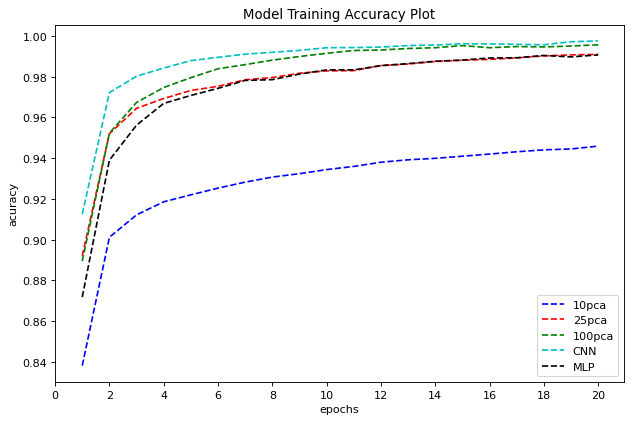

In [20]:
fig = plt.figure(figsize=(8,10), dpi=80)
plt.subplot(2,1,2)
col = ['b--', 'r--', 'g--', 'c--', 'k--', 'y--']
labels = []
for i in range(3):
    plt.plot(np.arange(1,epochs+1), pca_model_acc[i], col[i], label=str(pca_components[i])+'pca')
plt.plot(np.arange(1,epochs+1), cnn_acc, col[3], label='CNN')
plt.plot(np.arange(1,epochs+1), mlp_acc, col[4], label='MLP')
plt.title('Model Training Accuracy Plot')
plt.ylabel('acuracy')
plt.xlabel('epochs')
plt.xticks(np.arange(0,22,2))
#plt.yticks(np.arange(.80,1.0,0.01))
plt.legend()
plt.tight_layout()
fig.savefig('acc_plot.png')

In [52]:
print(f"CNN Train Acc: {cnn_acc[-1]},   PCA+MLP Train Acc: {pca_model_acc[2][-1]},   MLP Train Acc:, {mlp_acc[-1]}")
print(f"CNN Val Acc: {cnn_test_acc[-1]},   PCA+MLP Val Acc: {pca_test_acc[2][-1]},   MLP Val Acc:, {mlp_test_acc[-1]}")

CNN Train Acc: 0.9975166666666667,   PCA+MLP Train Acc: 0.99555,   MLP Train Acc:, 0.9906833333333334
CNN Val Acc: 0.9892,   PCA+MLP Val Acc: 0.9786,   MLP Val Acc:, 0.9758


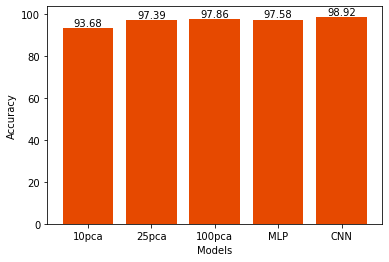

In [81]:
models = ['10pca', '25pca', '100pca', 'MLP', 'CNN']
params = [pca_params[0], pca_params[1], pca_params[2], count_parameters(mlp_model), count_parameters(cnn_model)]
accuracy = [pca_test_acc[0][-1]*100, pca_test_acc[1][-1]*100, pca_test_acc[2][-1]*100, mlp_test_acc[-1]*100, cnn_test_acc[-1]*100]

X_axis = np.arange(len(models))
width = 0.4 
ax = plt.bar(X_axis, accuracy, color = (0.9,0.2862,0.0,1))
plt.xticks(X_axis, models)
plt.ylabel("Accuracy")
plt.xlabel("Models")
plt.bar_label(ax)
plt.show()

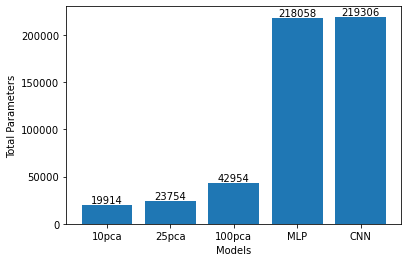

In [82]:
X_axis = np.arange(len(models))
width = 0.4
  
ax2 = plt.bar(X_axis, params)
plt.xticks(X_axis, models)
plt.ylabel("Total Parameters")
plt.xlabel("Models")
plt.bar_label(ax2)
plt.show()